# MRP : Implementing Pre-retrival Methods

In [1]:
#Importing Libraries 
import numpy as np
import os
from random import shuffle
import re
import urllib.request
import zipfile
import lxml.etree
#import wordcloud
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import math
import numpy
import string
from  nltk.tokenize  import word_tokenize
import datetime

### Reading TREC's ROBUST data collection 

In [2]:
# Set the Root file path - Path need to be changed
RootFilePath="C:/NareshPersonal/Python/MRP/cw12/"

#1.Loading all the collection documents 
#'test' is collections document folder name (might need to be changed) inside RootFilePath 
data_folder = os.path.join(RootFilePath, 'cw12')  

#2.Loading all the Queries 
df2=pd.read_csv(RootFilePath+"cw12_web2013.topics.txt",delimiter=":",names=['QueryNo','Query'])

#3.Loading MAP results for comparision later 
dfmap=pd.read_csv(RootFilePath+"cw12_mapresults/ClueWeb12_qmaporder.txt",delimiter=' ',names=['QueryNo','MAP'])

In [39]:

#3.Loading MAP results for comparision later 
dfmap=pd.read_csv(RootFilePath+"cw12_mapresults/ClueWeb12_qmaporder.txt",delimiter='\t',names=['QueryNo','MAP'])

In [43]:

#3.Loading MAP results for comparision later 
dfmap_rm=pd.read_csv(RootFilePath+"cw12_mapresults/clueWeb12Poolruns+clueweb12b-rm_mapresults.txt",delimiter='\t',names=['QueryNo','MAP_rm'])

In [44]:

#3.Loading MAP results for comparision later 
dfmap_sdm=pd.read_csv(RootFilePath+"cw12_mapresults/clueWeb12Poolruns+clueweb12b-sdm_mapresults.txt",delimiter='\t',names=['QueryNo','MAP_sdm'])

In [45]:

#3.Loading MAP results for comparision later 
dfmap_wikirm=pd.read_csv(RootFilePath+"cw12_mapresults/clueWeb12Poolruns+clueweb12b-wikiRm1_mapresults.txt",delimiter='\t',names=['QueryNo','MAP_wkrm'])

In [46]:

#3.Loading MAP results for comparision later 
dfmap_lcomb=pd.read_csv(RootFilePath+"cw12_mapresults/clueWeb12Poolruns+clueweb12b-linearcomb-context-all-map_mapresults.txt",delimiter='\t',names=['QueryNo','MAP_lcomb'])

In [48]:
dfmap_wikirm

,QueryNo,MAP_wkrm
0,201,0.1096
1,202,0.0000
2,203,0.0528
3,204,0.0337
4,205,0.0022
5,206,0.0393
6,207,0.0573
7,208,0.0468
8,209,0.0256
9,210,0.0094


### Prep Work for intermediate Calculation and document collection statistics

In [21]:
print("Start Time: ", datetime.datetime.now())
all_recipe_files = [os.path.join(data_folder, fname)
                    for fname in os.listdir(data_folder)]
documents = {}
doc_tokens_lower2={}
#i=0
for recipe_fname in all_recipe_files:
    bname = os.path.basename(recipe_fname)
    recipe_number = os.path.splitext(bname)[0]
    with open(recipe_fname, 'r',  encoding='utf8') as f:
        #print(i,recipe_number)
        #i=i+1
        documents[recipe_number] = f.read()
        doc_tokens = [t for t in word_tokenize(documents[recipe_number].lower())]
        doc_tokens_lower2[recipe_number] = [t.lower() for t in doc_tokens if t not in string.punctuation]
        
#Getting entire Corpus        
corpus_all_in_one = ' '.join([doc for doc in documents.values()])

#Printing Number of Docs, total Tokens and total Characters
print("Number of docs: {}".format(len(documents)))

try:  # py3
    all_tokens = [t for t in word_tokenize(corpus_all_in_one)]
except UnicodeDecodeError: 
    all_tokens = [t for t in word_tokenize(corpus_all_in_one.decode('utf-8'))]

print("Total number of tokens: {}".format(len(all_tokens)))

#print("Corpus size (char): {}".format(len(corpus_all_in_one)))

all_recipe_files_name = [fname for fname in os.listdir(data_folder)]

#Generating term frequency for entire collection for the purpose of calculating tf(t,D)
#from nltk.stem import PorterStemmer
#from  collections  import Counter
#stemmer = PorterStemmer()
all_tokens_lower = [t.lower() for t in all_tokens
                   if t not in string.punctuation]
#total_term_frequency_normalised = Counter(all_tokens_lower)

print("Total number of tokens lower & no punct: {}".format(len(all_tokens_lower)))
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-31 18:25:26.138096
Number of docs: 7905
Total number of tokens: 8197795
Total number of tokens lower & no punct: 7053327
End Time:  2018-07-31 18:30:04.540435


In [22]:
#for fname in all_recipe_files_name:
#    doc_tokens = [t for t in word_tokenize(documents[fname].lower())]
#    doc_tokens_lower2[fname] = [t.lower() for t in doc_tokens if t not in string.punctuation]

In [23]:
print("Start Time: ", datetime.datetime.now())
query_terms_doc_count={}
query_terms_total_count={}
for i in range(0,df2.index.size):
    for t in [t.lower() for t in word_tokenize(df2['Query'].iloc[i])if t not in string.punctuation]:
        query_terms_doc_count[t]=0
        query_terms_total_count[t]=0
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-31 18:30:48.759719
End Time:  2018-07-31 18:30:48.773080


In [24]:
print("Start Time: ", datetime.datetime.now())
for k,v in doc_tokens_lower2.items():
    for t in v:
        if t in query_terms_total_count.keys():
            query_terms_total_count[t]=query_terms_total_count[t]+1
    for t2 in query_terms_doc_count:
        if t2 in v:
            query_terms_doc_count[t2]=query_terms_doc_count[t2]+1
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-31 18:30:57.688306
End Time:  2018-07-31 18:31:24.551887


### Main code for the calculation of avgIDF, SCS(Q), maxSCQ, sumSCQ and avgSCQ metrics for each query

In [25]:
#Calculating avgIDF, SCS(Q), maxSCQ, maxVAR metrics for each query
print("Start Time: ", datetime.datetime.now())
davgidf={}
dscsq={}
dmaxscqt={}
dsumscqt={}
davgscqt={}
for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i])
                   if t not in string.punctuation]
    avgidf=0
    scsq=0
    maxscqt=0
    sumscqt=0
    avgscqt=0
    scqt=0
    for token in query_tokens:
        if query_terms_doc_count[token]>0:
            idft=math.log((len(documents)/query_terms_doc_count[token]),2) #Calculating idf(t) using log base 2
            avgidf=avgidf+idft
            scsq=scsq+math.log((len(all_tokens_lower)/query_terms_total_count[token]),2)
            scqt=(1+math.log(query_terms_total_count[token],2))*idft
            sumscqt=sumscqt+scqt
            if scqt>maxscqt:
                maxscqt=scqt
    davgidf[df2['QueryNo'].iloc[i]]=avgidf/len(query_tokens)
    dscsq[df2['QueryNo'].iloc[i]]=math.log((1/len(query_tokens)),2)+scsq/len(query_tokens)
    dmaxscqt[df2['QueryNo'].iloc[i]]=maxscqt
    dsumscqt[df2['QueryNo'].iloc[i]]=sumscqt
    davgscqt[df2['QueryNo'].iloc[i]]=sumscqt/len(query_tokens)
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-31 18:31:35.007743
End Time:  2018-07-31 18:31:35.028155


### Code for calculating avgVAR and maxVAR

In [26]:
print("Start Time: ", datetime.datetime.now())
from  collections  import Counter
doc_term_frequency_normalised2 = {}
for fname in all_recipe_files_name:
    doc_term_frequency_normalised2[fname] = Counter(doc_tokens_lower2[fname])
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-31 18:31:40.357134
End Time:  2018-07-31 18:31:41.556059


In [27]:
#Calculating weights for each term w(t,d) --Approx Run time 10 min.
print("Start Time: ", datetime.datetime.now())
wtd={}
for k, v in doc_term_frequency_normalised2.items():
    for i in range(0,df2.index.size):
        query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i])
                   if t not in string.punctuation]
        for token in query_tokens:
            if v.get(token)!=None:
                wtd[k+"/"+token]=(math.log2(1+v.get(token))*math.log((len(documents)/query_terms_doc_count[token]),2))/len(doc_tokens_lower2[k])
print("End Time: ", datetime.datetime.now())           

Start Time:  2018-07-31 18:31:44.096196
End Time:  2018-07-31 18:33:15.787206


In [28]:
#main code to calculate maxVAR and avgVAR
print("Start Time: ", datetime.datetime.now())
dmaxvar={}
davgvar={}
for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i]) if t not in string.punctuation]
    maxvar=0
    sumvar=0
    for token in query_tokens:
        dvar={}
        for key in wtd:
            if re.fullmatch('.*'+'/'+token, key):
                dvar[str(df2['QueryNo'].iloc[i])+'/'+key]=wtd[key]
        #print(dvar)
        if len(dvar)>0:
            sumvar=sumvar+np.var(np.array(list(dvar.values())))
            if np.var(np.array(list(dvar.values())))>maxvar:
                maxvar=np.var(np.array(list(dvar.values())))
    dmaxvar[df2['QueryNo'].iloc[i]]=maxvar
    davgvar[df2['QueryNo'].iloc[i]]=sumvar/len(query_tokens)
print("End Time: ", datetime.datetime.now())                

Start Time:  2018-07-31 18:33:21.155012
End Time:  2018-07-31 18:34:15.398586


### Code for calculating avgPMI and maxPMI

In [29]:
query_terms_doc_count_t1t2={}
for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i]) if t not in string.punctuation]
    for j in range(0,len(query_tokens)):
        for k in range(j+1,len(query_tokens)):
            query_terms_doc_count_t1t2[query_tokens[j],query_tokens[k]]=0                   

In [30]:
print("Start Time: ", datetime.datetime.now())
for k,v in doc_tokens_lower2.items():
    for k1,k2 in query_terms_doc_count_t1t2.keys():
        if k1 in v and k2 in v:
            query_terms_doc_count_t1t2[k1,k2]=query_terms_doc_count_t1t2[k1,k2]+1
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-31 18:34:20.961830
End Time:  2018-07-31 18:35:04.575669


In [31]:
## Main Code to calculate TERM RELATEDNESS metrics i.e. avgPMI and maxPMI, 
print("Start Time: ", datetime.datetime.now())
davgpmi = {}
dmaxpmi = {}
#Program to Calculate PMI(t1,t2)
D=len(documents) #Total number documents |D|
#D=len(all_tokens_lower) #Total number of terms in entire document colleciton after removing punctuation etc.

for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i]) if t not in string.punctuation]
    #print(query_tokens)
    n=0
    avgpmi=0
    maxpmi=0
    for j in range(0,len(query_tokens)):
        if len(query_tokens)==1:
            avgpmi=math.log2(1)
            n=1        
        else:
            for k in range(j+1,len(query_tokens)):
                n=n+1
                if query_terms_doc_count_t1t2[query_tokens[j],query_tokens[k]] !=0:
                    pmi=(query_terms_doc_count_t1t2[query_tokens[j],query_tokens[k]]*D)/(query_terms_doc_count[query_tokens[j]]*query_terms_doc_count[query_tokens[k]])
                if pmi!=0:
                    avgpmi=avgpmi+math.log2(pmi)
                    if math.log2(pmi)>maxpmi:
                        maxpmi=math.log2(pmi)
    davgpmi[df2['QueryNo'].iloc[i]]=avgpmi/n
    dmaxpmi[df2['QueryNo'].iloc[i]]=maxpmi
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-31 18:35:06.938449
End Time:  2018-07-31 18:35:06.948477


In [32]:
df2.insert(len(df2.columns),'avgidf',99)
df2['avgidf']=df2['QueryNo'].map(davgidf)
df2.insert(len(df2.columns),'scsq',99)
df2['scsq']=df2['QueryNo'].map(dscsq)
df2.insert(len(df2.columns),'maxscqt',99)
df2['maxscqt']=df2['QueryNo'].map(dmaxscqt)
df2.insert(len(df2.columns),'sumscqt',99)
df2['sumscqt']=df2['QueryNo'].map(dsumscqt)
df2.insert(len(df2.columns),'avgscqt',99)
df2['avgscqt']=df2['QueryNo'].map(davgscqt)
df2.insert(len(df2.columns),'maxvar',99)
df2['maxvar']=df2['QueryNo'].map(dmaxvar)
df2.insert(len(df2.columns),'avgvar',99)
df2['avgvar']=df2['QueryNo'].map(davgvar)
df2.insert(len(df2.columns),'avgpmi',99)
df2['avgpmi']=df2['QueryNo'].map(davgpmi)
df2.insert(len(df2.columns),'maxpmi',99)
df2['maxpmi']=df2['QueryNo'].map(dmaxpmi)

In [56]:
df3=pd.merge(df2,dfmap,on='QueryNo')
df3.head()

,QueryNo,Query,avgidf,scsq,maxscqt,sumscqt,avgscqt,maxvar,avgvar,avgpmi,maxpmi,MAP
0,201,raspberry pi,6.025217,12.025576,65.862078,129.244117,64.622058,0.001412,0.001349,5.788385,5.788385,0.0736
1,202,uss carl vinson,6.142256,12.719465,61.760591,173.841948,57.947316,0.003146,0.002589,5.710723,5.902942,0.0000
2,203,reviews of les miserables,4.074786,9.140648,62.781434,175.342884,43.835721,0.007356,0.003351,1.385154,5.462646,0.0214
3,204,rules of golf,2.929780,7.324090,61.613248,115.821285,38.607095,0.019699,0.007061,0.779926,2.050287,0.0217
4,205,average charitable donation,4.818483,10.661234,64.776518,166.683807,55.561269,0.001359,0.000799,2.825212,4.591945,0.0158


In [57]:
df3=pd.merge(df3,dfmap_rm,on='QueryNo')
df3=pd.merge(df3,dfmap_sdm,on='QueryNo')
df3=pd.merge(df3,dfmap_wikirm,on='QueryNo')
df3=pd.merge(df3,dfmap_lcomb,on='QueryNo')

In [58]:
df3.head()

,QueryNo,Query,avgidf,scsq,maxscqt,sumscqt,avgscqt,maxvar,avgvar,avgpmi,maxpmi,MAP,MAP_rm,MAP_sdm,MAP_wkrm,MAP_lcomb
0,201,raspberry pi,6.025217,12.025576,65.862078,129.244117,64.622058,0.001412,0.001349,5.788385,5.788385,0.0736,0.1045,0.1089,0.1096,0.1124
1,202,uss carl vinson,6.142256,12.719465,61.760591,173.841948,57.947316,0.003146,0.002589,5.710723,5.902942,0.0000,0.0000,0.0000,0.0000,0.0000
2,203,reviews of les miserables,4.074786,9.140648,62.781434,175.342884,43.835721,0.007356,0.003351,1.385154,5.462646,0.0214,0.0273,0.0410,0.0528,0.0595
3,204,rules of golf,2.929780,7.324090,61.613248,115.821285,38.607095,0.019699,0.007061,0.779926,2.050287,0.0217,0.0143,0.0244,0.0337,0.0343
4,205,average charitable donation,4.818483,10.661234,64.776518,166.683807,55.561269,0.001359,0.000799,2.825212,4.591945,0.0158,0.0028,0.0256,0.0022,0.0507


             avgidf      scsq   avgscqt   maxscqt   sumscqt    avgvar  \
avgidf     1.000000  0.889820  0.904766  0.038471 -0.047102 -0.035515   
scsq       0.889820  1.000000  0.747985 -0.246005 -0.321799 -0.013496   
avgscqt    0.904766  0.747985  1.000000  0.163803 -0.124863  0.006446   
maxscqt    0.038471 -0.246005  0.163803  1.000000  0.175647 -0.153626   
sumscqt   -0.047102 -0.321799 -0.124863  0.175647  1.000000 -0.117879   
avgvar    -0.035515 -0.013496  0.006446 -0.153626 -0.117879  1.000000   
maxvar    -0.163864 -0.168074 -0.161335 -0.101442  0.067415  0.895003   
avgpmi     0.901181  0.757614  0.885582  0.139603 -0.098237 -0.104608   
maxpmi     0.544895  0.280088  0.429566  0.199894  0.475286 -0.221852   
MAP       -0.008128  0.065653 -0.004979 -0.065176  0.049471 -0.178441   
MAP_rm     0.039476 -0.026856 -0.018458  0.103695  0.395782 -0.171600   
MAP_sdm    0.035099  0.001697  0.001058  0.020956  0.385817 -0.180103   
MAP_wkrm   0.067407  0.003542  0.021742  0.091182  

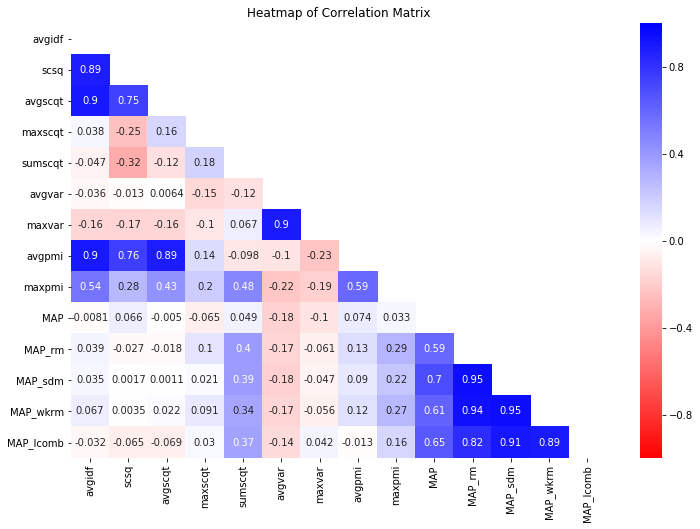

In [66]:
# Plotting correlation matrix 
import matplotlib.pyplot as plt
import seaborn as sns
corr = df3[['avgidf','scsq','avgscqt','maxscqt','sumscqt','avgvar','maxvar','avgpmi','maxpmi','MAP','MAP_rm','MAP_sdm',
            'MAP_wkrm','MAP_lcomb']].corr()
print(corr)
plt.rc('figure', figsize=(12,8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values, cmap='bwr_r', vmin=-1, vmax=1, annot=True, mask=mask)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [19]:
#Printing Correlation of Pre-retrieval metrices with MAP
print("Corr avgIDF and MAP : ", numpy.corrcoef(df2['avgidf'], dfmap['MAP'])[0, 1])
print("Corr SCS(Q) and MAP : ",numpy.corrcoef(df2['scsq'], dfmap['MAP'])[0, 1])
print("Corr MaxSCQ and MAP : ",numpy.corrcoef(df2['maxscqt'], dfmap['MAP'])[0, 1])
print("Corr maxVAR and MAP : ",numpy.corrcoef(df2['maxvar'], dfmap['MAP'])[0, 1])
print("Corr avgPMI and MAP : ",numpy.corrcoef(df2['avgpmi'], dfmap['MAP'])[0, 1])
print("Corr avgIDF and SCS(Q) : ",numpy.corrcoef(df2['avgidf'], df2['scsq'])[0, 1])

Corr avgIDF and MAP :  0.109436816157
Corr SCS(Q) and MAP :  0.0710765950405
Corr MaxSCQ and MAP :  0.197585334558
Corr maxVAR and MAP :  0.190088725948
Corr avgPMI and MAP :  0.0494407037784
Corr avgIDF and SCS(Q) :  0.949072364034


In [64]:
df3[df3['MAP']==0]
#df3

,QueryNo,Query,avgidf,scsq,maxscqt,sumscqt,avgscqt,maxvar,avgvar,avgpmi,maxpmi,MAP,MAP_rm,MAP_sdm,MAP_wkrm,MAP_lcomb
1,202,uss carl vinson,6.142256,12.719465,61.760591,173.841948,57.947316,0.003146,0.002589,5.710723,5.902942,0.0,0.0000,0.0000,0.0000,0.0000
24,225,black and gold,2.955466,7.836768,60.035899,109.658092,36.552697,0.001722,0.000731,0.926431,2.478740,0.0,0.0000,0.0000,0.0000,0.0000
36,237,lump in throat,4.195226,9.343377,65.443352,131.591548,43.863849,0.000850,0.000500,1.984110,5.439823,0.0,0.0000,0.0000,0.0000,0.0000
44,245,roosevelt island,4.998164,11.468103,62.234222,110.379620,55.189810,0.009585,0.005387,3.405329,3.405329,0.0,0.0002,0.0002,0.0008,0.0004


### References:
https://github.com/bonzanini/nlp-tutorial/blob/master/notebooks/01%20recipes_exploratory_analysis.ipynb

https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/

https://gist.github.com/amontalenti/7975313